In [4]:
# Gender classification using Vision Transformers (ViT)
# import libraries
import pandas as pd
import os
import numpy as np
import cv2
import glob
import random
import keras
import tensorflow as tf
from keras.optimizers import Adam
from keras import layers
from keras.models import Sequential,load_model,Model
from keras.utils import to_categorical
from keras.layers import Conv2D,Layer,MaxPooling2D,Dense,Dropout,BatchNormalization,Flatten,Input,Activation
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# image configuration
image_size = 128
num_channels = 3
input_shape = (image_size, image_size, num_channels)
num_classes = 2

# hyperparameters configuration
patch_size = 8
num_patches = (image_size // patch_size) * (image_size // patch_size)
hidden_dim = 128 # the size of the feature vectors or embeddings for representing the input data
num_heads = 8  # Number of attention heads in the multi-head attention layer
transformer_units = [hidden_dim * 2,hidden_dim,]  #  Dimension of the feed-forward neural network (MLP) in each transformer block
transformer_layers = 12 # Number of transformer blocks
mlp_head_units = [2048,1024,]  # Size of the dense layers of the final classifier

In [6]:
# load the dataset
path = "./gender_dataset_face/"
image_files = [f for f in glob.glob(path + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [7]:
# images and labels arrays
images = []
labels = []
for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (image_size,image_size))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = image/255.0 # data normalizarion
    images.append(np.array(image))

    label = img.split(os.path.sep)[-2] # gender_dataset_face\woman\img
    if label == "woman":
        label = 1
    else:
        label = 0
    labels.append([label])

images = np.array(images)
labels = np.array(labels,dtype=np.uint64)

In [8]:
# split data into training & testing
(x_train, x_test, y_train, y_test) = train_test_split(images, labels,test_size=0.3, random_state=42)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
print(f"x_train: {x_train.shape} | y_train: {y_train.shape}")
print(f"x_test: {x_test.shape} | y_test: {y_test.shape}")

x_train: (1614, 128, 128, 3) | y_train: (1614, 2)
x_test: (693, 128, 128, 3) | y_test: (693, 2)


In [9]:
# converting images into 16X16 non-overlapping patches
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates = [1,1,1,1],
            padding = "VALID",
            )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 128 X 128
Patch size: 8 X 8
Patches per image: 256
Elements per patch: 192


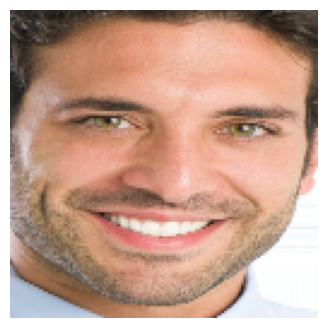

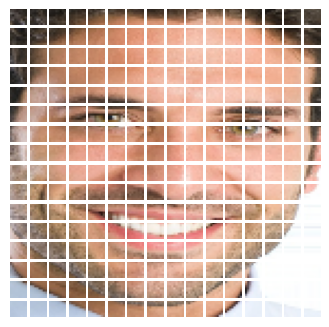

In [11]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

image = tf.convert_to_tensor([image])
patches = Patches(patch_size)(image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

In [12]:
# Creating the patch encoder layer => will linearly transform a patch by projecting it into a vector of size hidden_dim. it also adds a learnable position embedding to the projected vector.
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, hidden_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=hidden_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=hidden_dim)

    def call(self, patch):
        positions = tf.expand_dims(tf.range(0, self.num_patches, 1), axis=0)
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [14]:
def vit():
    inputs = keras.Input(shape=input_shape)
    # # Augment data.
    # augmented = data_augmentation(inputs)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, hidden_dim)(patches)

    # multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # multi-head attention layer
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim, dropout=0.1)(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])


    global_avg_pooling = layers.GlobalAveragePooling1D()(encoded_patches)
    features = mlp(global_avg_pooling, hidden_units=mlp_head_units, dropout_rate=0.5)
    outputs = layers.Dense(num_classes, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
# compile the model
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    checkpoint = ModelCheckpoint("./check/checkpoint.weights.h5",monitor="val_acc", save_best_only=True, save_weights_only=True)
    early_stopping = EarlyStopping(monitor='val_loss',min_delta=0, patience=3, verbose=1, restore_best_weights=True)
    callbacks_list = [early_stopping,checkpoint]

    history = model.fit( x_train, y_train, batch_size=32, epochs=100, validation_split=0.1, validation_data=(x_test, y_test), verbose=1, callbacks=callbacks_list)

    return history

In [17]:
vit_classifier = vit()
history = run_experiment(vit_classifier)

Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 1.3207 - accuracy: 0.5068

51/51 [==============================] - 70s 551ms/step - loss: 1.3207 - accuracy: 0.5068 - val_loss: 0.6935 - val_accuracy: 0.5339
Epoch 2/100
51/51 [==============================] - ETA: 0s - loss: 0.7173 - accuracy: 0.5836

51/51 [==============================] - 24s 474ms/step - loss: 0.7173 - accuracy: 0.5836 - val_loss: 0.6261 - val_accuracy: 0.6724
Epoch 3/100
51/51 [==============================] - ETA: 0s - loss: 0.6328 - accuracy: 0.6760

51/51 [==============================] - 26s 518ms/step - loss: 0.6328 - accuracy: 0.6760 - val_loss: 0.5791 - val_accuracy: 0.7330
Epoch 4/100
51/51 [==============================] - ETA: 0s - loss: 0.5986 - accuracy: 0.7119

51/51 [==============================] - 26s 516ms/step - loss: 0.5986 - accuracy: 0.7119 - val_loss: 0.5741 - val_accuracy: 0.7100
Epoch 5/100
51/51 [==============================] - ETA: 0s - loss: 0.5399 - accuracy: 0.7546

51/51 [==============================] - 26s 514ms/step - loss: 0.5399 - accuracy: 0.7546 - val_loss: 0.6664 - val_accuracy: 0.6118
Epoch 6/100
51/51 [==============================] - ETA: 0s - loss: 0.4632 - accuracy: 0.7924

51/51 [==============================] - 26s 516ms/step - loss: 0.4632 - accuracy: 0.7924 - val_loss: 0.5850 - val_accuracy: 0.7417
Epoch 7/100
51/51 [==============================] - ETA: 0s - loss: 0.4589 - accuracy: 0.8055

51/51 [==============================] - 26s 517ms/step - loss: 0.4589 - accuracy: 0.8055 - val_loss: 0.4934 - val_accuracy: 0.7417
Epoch 8/100
51/51 [==============================] - ETA: 0s - loss: 0.4285 - accuracy: 0.8079

51/51 [==============================] - 25s 492ms/step - loss: 0.4285 - accuracy: 0.8079 - val_loss: 0.4911 - val_accuracy: 0.7821
Epoch 9/100
51/51 [==============================] - ETA: 0s - loss: 0.3983 - accuracy: 0.8482

51/51 [==============================] - 26s 516ms/step - loss: 0.3983 - accuracy: 0.8482 - val_loss: 0.6493 - val_accuracy: 0.6479
Epoch 10/100
51/51 [==============================] - ETA: 0s - loss: 0.3321 - accuracy: 0.8625

51/51 [==============================] - 27s 528ms/step - loss: 0.3321 - accuracy: 0.8625 - val_loss: 0.5575 - val_accuracy: 0.7561
Epoch 11/100
51/51 [==============================] - ETA: 0s - loss: 0.3428 - accuracy: 0.8575Restoring model weights from the end of the best epoch: 8.


51/51 [==============================] - 27s 531ms/step - loss: 0.3428 - accuracy: 0.8575 - val_loss: 0.6257 - val_accuracy: 0.7850
Epoch 11: early stopping


In [18]:
# prediction & evaluation
results = vit_classifier.evaluate(x_test,y_test)
preds = vit_classifier.predict(x_test)
print('ViT Model accuracy {}%'.format(round(results[1]*100, 2)))

22/22 [==============================] - 5s 140ms/step
ViT Model accuracy 78.21%


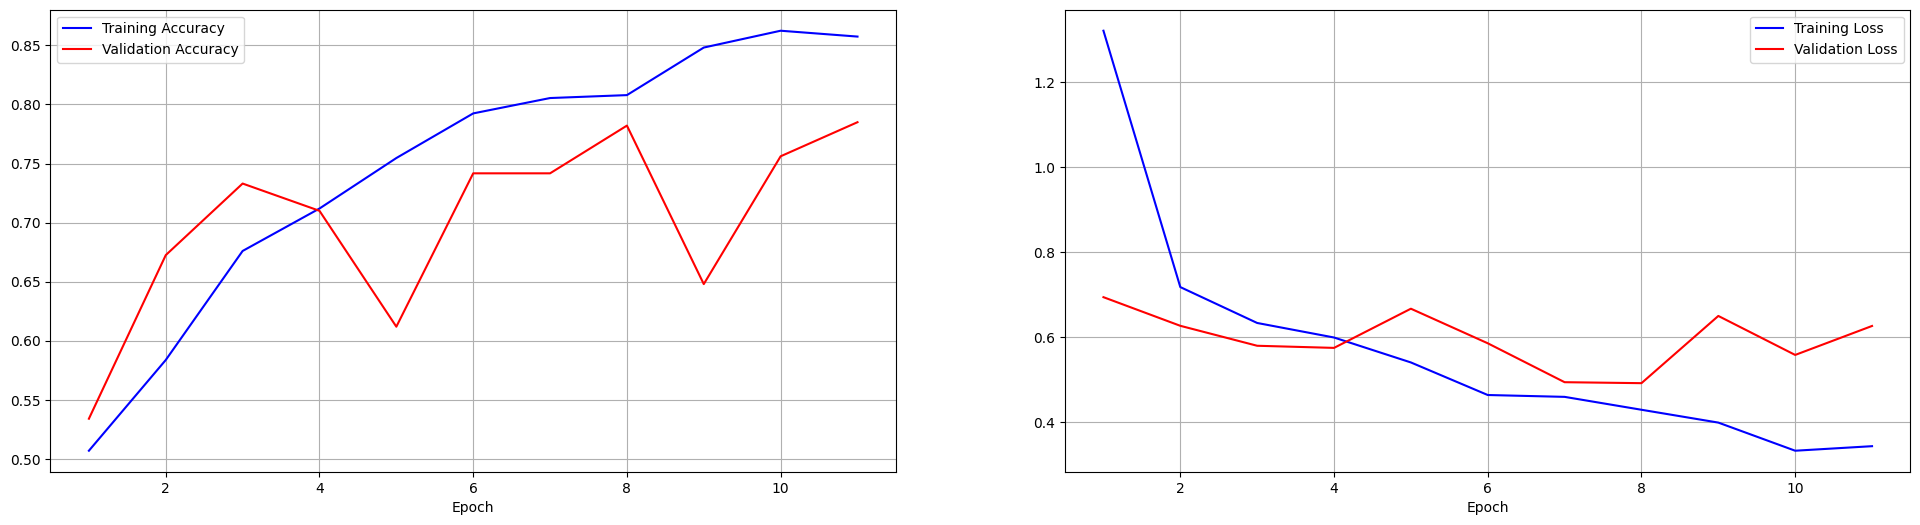

In [19]:
# visualise training and testing accuracy & loss
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(24, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()


plot_results(history)

In [23]:
predictions_ViT = vit_classifier.predict(x_test)
y_pred_ViT = (predictions_ViT>= 0.5).astype(int)[:,0]
y_test_p = y_test.astype(int)[:,0]
print ("Accuracy = ", metrics.accuracy_score(y_test_p, y_pred_ViT))

22/22 [==============================] - 3s 145ms/step
Accuracy =  0.7821067821067821


In [28]:
print( "Actual value :" , y_test_p[5], "/ Predicted value :" , y_pred_ViT[5])

Actual value : 1 / Predicted value : 1


<Axes: >

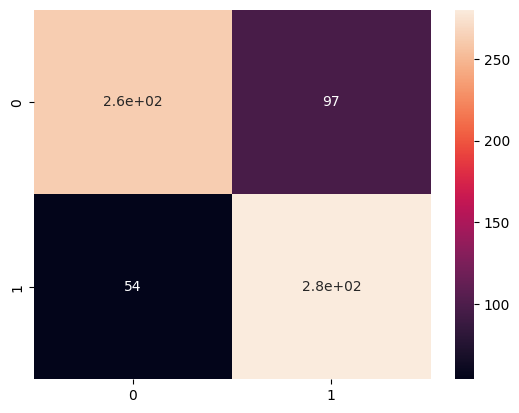

In [29]:
# confusion matrix
cm=confusion_matrix(y_test_p, y_pred_ViT)
sns.heatmap(cm, annot=True)

In [21]:
# saving model
vit_classifier.save("Gender_ViT_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
#Test ViT model
ViT_model = load_model('Gender_ViT_model.model', compile=False)

predictions_ViT = ViT_model.predict(x_test)
y_pred_ViT = (predictions_ViT>= 0.5).astype(int)[:,0]
y_test_p = y_test.astype(int)[:,0]
print ("Accuracy = ", metrics.accuracy_score(y_test_p, y_pred_ViT))

22/22 [==============================] - 5s 140ms/step
Accuracy =  0.7821067821067821
